In [2]:

import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from PIL import Image

In [ ]:
os.makedirs('data', exist_ok=True)

import shutil

shutil.copy('./cars/cars_meta.mat','./data/cars_meta.mat')
shutil.copy('./cars/cars_train_annos.mat','./data/cars_train_annos.mat')
shutil.copy('./cars/cars_test_annos_withlabels_eval.mat','./data/cars_test_annos_withlabels_eval.mat')

'./data/cars_test_annos_withlabels_eval.mat'

In [ ]:
import zipfile
if not os.path.exists('data/cars_test'):
    with zipfile.ZipFile('./cars/CarDatasets.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

import scipy.io as sio

In [25]:
cars_meta= sio.loadmat('data/cars_meta.mat')

CarsNamesDict= dict()
ind = 1
for car in cars_meta['class_names'][0]:
  CarsNamesDict[ind] = car[0]
  ind+=1

print(CarsNamesDict[1])

cars_train_annos = sio.loadmat('data/cars_train_annos.mat')
print(cars_train_annos['annotations'][0][4])
print(cars_train_annos['annotations'][0][0][5][0])

cars_test_annos = sio.loadmat('data/cars_test_annos_withlabels_eval.mat')

print(cars_test_annos['annotations'][0][0][4][0][0])
print(cars_test_annos['annotations'][0][0][5][0])

train_dir='data/cars_train'
test_dir='data/cars_test'


AM General Hummer SUV 2000
(array([[14]], dtype=uint8), array([[36]], dtype=uint8), array([[133]], dtype=uint8), array([[99]], dtype=uint8), array([[106]], dtype=uint8), array(['00005.jpg'], dtype='<U9'))
00001.jpg
181
00001.jpg


In [27]:
for carDir in CarsNamesDict:
  os.makedirs(train_dir + "/copied/"+CarsNamesDict[carDir], exist_ok=True)

for car_image in cars_train_annos['annotations'][0]:
  index = car_image[4][0][0]
  image_path = car_image[5][0]
  shutil.copy(train_dir + "/cars_train/"+image_path, train_dir + "/copied/"+CarsNamesDict[index]+"/"+image_path)

for carDir in CarsNamesDict:
  os.makedirs(test_dir + "/copied/"+CarsNamesDict[carDir], exist_ok=True)

for car_image in cars_test_annos['annotations'][0]:
  index = car_image[4][0][0]
  image_path = car_image[5][0]
  shutil.copy(test_dir + "/cars_test/"+image_path, test_dir + "/copied/"+CarsNamesDict[index]+"/"+image_path)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.models import resnet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_resnet50():
    model = resnet50(pretrained=False)
    return model



In [3]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root='data/cars_train/copied', transform=transform_train)
val_dataset = datasets.ImageFolder(root='data/cars_test/copied', transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

In [4]:
def train_one_epoch(model, optimizer, criterion, dataloader):
    model.train()
    running_loss = 0.
    correct = 0
    total = 0

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, criterion, dataloader):
    model.eval()
    running_loss = 0.
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
num_epochs = 10

# Модель с AdaMax
model_adamax = get_resnet50().to(device)
optimizer_adamax = optim.Adamax(model_adamax.parameters(), lr=0.001) 
criterion = nn.CrossEntropyLoss()

# Модель с Adam
model_adam = get_resnet50().to(device)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001) 

history_adamax = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
history_adam   = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Start training.")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # AdaMax 
    train_loss_a_max, train_acc_a_max = train_one_epoch(model_adamax, optimizer_adamax, criterion, train_loader)
    val_loss_a_max , val_acc_a_max   = validate(model_adamax , criterion , val_loader)

    history_adamax['train_loss'].append(train_loss_a_max)
    history_adamax['train_acc'].append(train_acc_a_max)
    history_adamax['val_loss'].append(val_loss_a_max)
    history_adamax['val_acc'].append(val_acc_a_max)

    print(f"AdaMax - Train Loss: {train_loss_a_max:.4f}, Train Acc: {train_acc_a_max:.4f}, Val Loss: {val_loss_a_max:.4f}, Val Acc: {val_acc_a_max:.4f}")

    # Adam 
    train_loss_adam , train_acc_adam  = train_one_epoch(model_adam , optimizer_adam , criterion , train_loader)
    val_loss_adam  , val_acc_adam     = validate(model_adam , criterion , val_loader)

    history_adam['train_loss'].append(train_loss_adam )
    history_adam['train_acc'].append(train_acc_adam )
    history_adam['val_loss'].append(val_loss_adam )
    history_adam['val_acc'].append(val_acc_adam )

    print(f"Adam   - Train Loss: {train_loss_adam :.4f}, Train Acc: {train_acc_adam :.4f}, Val Loss: {val_loss_adam :.4f}, Val Acc: {val_acc_adam :.4f}")

print("Training finished.")

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Start training...
Epoch 1/10


In [ ]:
epochs_range = range(1,num_epochs+1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range,history_adamax['train_acc'], label='AdaMax Train Acc')
plt.plot(epochs_range,history_adamax['val_acc'], label='AdaMax Val Acc')
plt.plot(epochs_range,history_adam['train_acc'], label='Adam Train Acc')
plt.plot(epochs_range,history_adam['val_acc'], label='Adam Val Acc')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,history_adamax['train_loss'], label='AdaMax Train Loss')
plt.plot(epochs_range,history_adamax['val_loss'], label='AdaMax Val Loss')
plt.plot(epochs_range,history_adam['train_loss'], label='Adam Train Loss')
plt.plot(epochs_range,history_adam['val_loss'], label='Adam Val Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

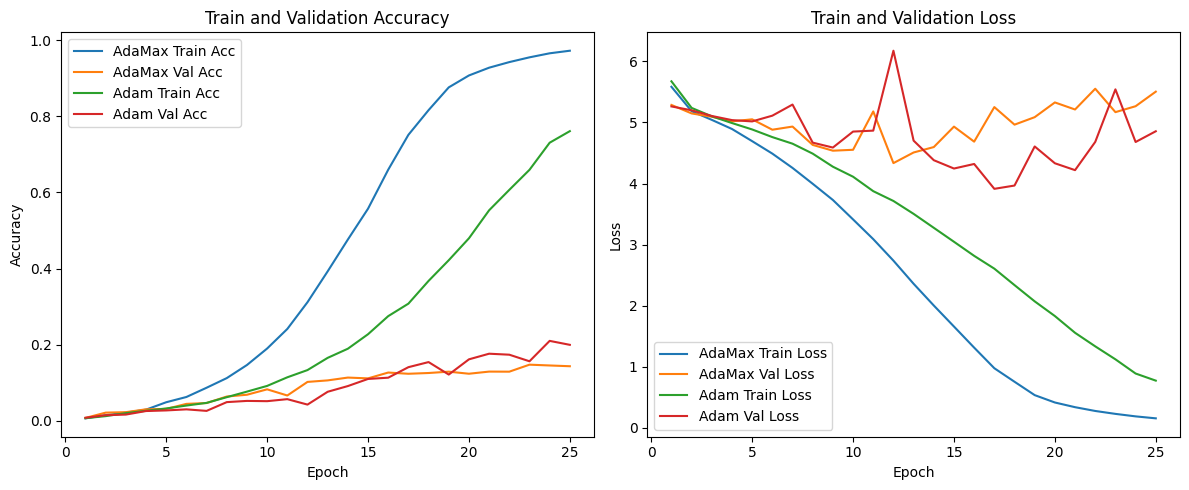

In [ ]:
import matplotlib.pyplot as plt

num_epochs = 25 

history_adamax = {
    "train_loss": [
       5.5851, 5.1852, 5.0430, 4.8937, 4.6942, 4.4901, 4.2558, 3.9960, 3.7306, 3.4119, 3.0894, 2.7367, 2.3576, 2.0017, 1.6571, 1.3116, 0.9739, 0.7525, 0.5334, 0.4127, 0.3358, 0.2739, 0.2262, 0.1853, 0.1531
    ],
    "train_acc": [
        0.0064, 0.0147, 0.0214, 0.0293, 0.0487, 0.0625, 0.0868, 0.1121, 0.1465, 0.1898, 0.2412, 0.3115, 0.3926, 0.4761, 0.5572, 0.6596, 0.7512, 0.8161, 0.8759, 0.9072, 0.9276, 0.9423, 0.9548, 0.9654, 0.9722
    ],
    "val_loss": [
        5.2876, 5.1486, 5.0942, 5.0186, 5.0519, 4.8817, 4.9332, 4.6328, 4.5381, 4.5529, 5.1812, 4.3347, 4.5087, 4.5974, 4.9325, 4.6862, 5.2526, 4.9646, 5.0873, 5.3287, 5.2130, 5.5531, 5.1696, 5.2666, 5.5053
    ],
    "val_acc": [
    0.0075, 0.0214, 0.0226, 0.0301, 0.0312, 0.0444, 0.0466, 0.0637, 0.0684, 0.0826, 0.0664, 0.1021, 0.1061, 0.1135, 0.1114, 0.1267, 0.1235, 0.1255, 0.1290, 0.1236, 0.1292, 0.1290, 0.1474, 0.1453, 0.1433
    ]
}

history_adam = {
    "train_loss": [
    5.6747, 5.2390, 5.1011, 4.9910, 4.8859, 4.7607, 4.6529, 4.4898, 4.2757, 4.1116, 3.8750, 3.7143, 3.5031, 3.2746, 3.0460, 2.8153, 2.6055, 2.3359, 2.0696, 1.8290, 1.5545, 1.3325, 1.1200, 0.8874, 0.7708
],
   "train_acc": [
    0.0068, 0.0122, 0.0201, 0.0263, 0.0323, 0.0400, 0.0470, 0.0620, 0.0766, 0.0916, 0.1142, 0.1332, 0.1653, 0.1893, 0.2274, 0.2749, 0.3077, 0.3675, 0.4218, 0.4794, 0.5530, 0.6066, 0.6593, 0.7305, 0.7609
],
    'val_loss': [5.2632, 5.1999, 5.1069, 5.0391, 5.0177, 5.1118, 5.2938, 4.6701, 4.5894, 4.8512, 4.8667, 6.1760, 4.7029, 4.3823, 4.2458, 4.3204, 3.9132, 3.9670, 4.6073, 4.3320, 4.2194, 4.6819, 5.5427, 4.6805, 4.8564],
    'val_acc': [0.0080, 0.0146, 0.0163, 0.0256, 0.0272, 0.0300, 0.0260, 0.0490, 0.0522, 0.0515, 0.0568, 0.0425, 0.0762, 0.0912, 0.1099, 0.1132, 0.1408, 0.1542, 0.1214, 0.1614, 0.1762, 0.1736, 0.1563, 0.2099, 0.1995]
}

epochs_range = range(1,num_epochs+1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range , history_adamax['train_acc'], label='AdaMax Train Acc')
plt.plot(epochs_range , history_adamax['val_acc'], label='AdaMax Val Acc')
plt.plot(epochs_range , history_adam['train_acc'], label='Adam Train Acc')
plt.plot(epochs_range , history_adam['val_acc'], label='Adam Val Acc')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1 ,2 ,2)
plt.plot(epochs_range , history_adamax['train_loss'], label='AdaMax Train Loss')
plt.plot(epochs_range , history_adamax['val_loss'], label='AdaMax Val Loss')
plt.plot(epochs_range , history_adam['train_loss'], label='Adam Train Loss')
plt.plot(epochs_range , history_adam['val_loss'], label='Adam Val Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()